# 卷积分类

![image5.png](mdfiles/image5.png)


## 深度可分离卷积
深度可分离卷积（Depthwise Separable Convolution）是一种高效的卷积操作，旨在减少卷积神经网络中的计算量和参数数量。它将标准卷积操作分解为两个独立的步骤：深度卷积（Depthwise Convolution）和逐点卷积（Pointwise Convolution）。

它是为了解决标准卷积的计算复杂度高和参数量大的问题而提出的。VGG、ResNet、SENet、DenseNet 等经典卷积神经网络大多采用标准卷积（Standard Convolution），但标准卷积存在以下缺点：
1. 速度较慢、参数量大
2. 计算复杂度高


深度可分离卷积就是谷歌在 MobileNet v1 中提出的一种轻量化卷积方法，通过将标准卷积分解为深度卷积和逐点卷积，大大减少了计算量和参数数量，从而提高了模型的效率。

深度可分离卷积（Depthwise Separable Convolution）由 Depthwise（DW）和 Pointwise（PW）这两部分卷积组合而成的。

回忆： 输入 m 个尺寸为 h, w 的特征图，通过卷积计算获得 n 个通道尺寸为 h′ 与 w′ 的特征图的计算过程。
![image3.png](mdfiles/image3.png)

我们将特征图与一个卷积核计算的过程展开一下，请看下图。一个卷积核中的 m 个卷积分别与输入特征图的 m 个通道数据进行卷积计算，生成一个中间结果，然后 m 个中间结果按位求和，最终就能获得 n 个输出特征图中的一个特征图。

![image7.png](mdfiles/image7.png)

Depthwise（DW）卷积 如下图

那什么是 DW 卷积呢？DW 卷积就是有 m 个卷积核的卷积，每个卷积核中的通道数为 1，这 m 个卷积核分别与输入特征图对应的通道数据做卷积运算，所以 DW 卷积的输出是有 m 个通道的特征图。通常来说，DW 卷积核的大小是 3x3 的。

![image8.png](mdfiles/image8.png)


Pointwise（PW）卷积 如下图
深度可分离卷积的目标是轻量化标准卷积计算的，所以它是可以来替换标准卷积的，这也意味着原卷积计算的输出尺寸是什么样，替换后的输出尺寸也要保持一致。

深度可分离卷积中，我们最终要获得一个具有 n 个通道的输出特征图，而刚才介绍的 DW 卷积显然没有达到，并且 DW 卷积也忽略了输入特征图通道之间的信息。

在 DW 之后我们还要加一个 PW 卷积。PW 卷积也叫做逐点卷积。PW 卷积的主要作用就是将 DW 输出的 m 个特征图结合在一起考虑，再输出一个具有 n 个通道的特征图。

在卷积神经网络中，我们经常可以看到使用 1x1 的卷积，1x1 的卷积主要作用就是升维与降维。所以，在 DW 的输出之后的 PW 卷积，就是 n 个卷积核的 1x1 的卷积，每个卷积核中有 m 个通道的卷积数据。

![image9.png](mdfiles/image9.png)

原始标准卷积的计算量为：
k * k * m * n * h' * w'

深度可分离卷积的计算量为：
DW: k * k * m * h' * w'
PW: 1 * 1 * m * n * h' * w'

原始/深度可分离卷积计算量比为：
(k * k * m * n * h' * w') / (k * k * m * h' * w' + 1 * 1 * m * n * h' * w') = n / (1/n + 1/k^2)

torch.Size([1, 3, 500, 500])


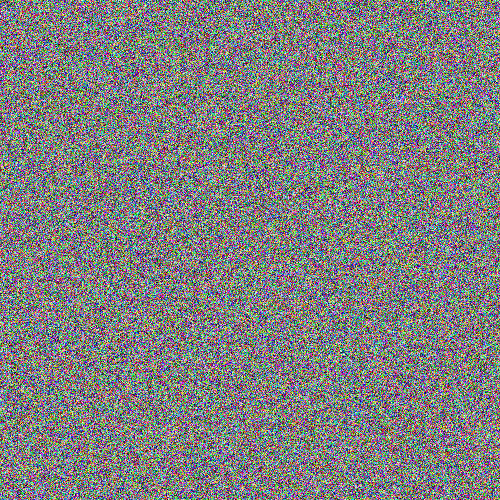

3 3


In [14]:
import torch
import torch.nn as nn
from PIL import Image

# 生成一个三通道的500x500特征图
x = torch.rand((3, 500, 500)).unsqueeze(0)
print(x.shape)
# display image in RGB 3 channels * 255
img = Image.fromarray((x.squeeze(0).permute(1, 2, 0).numpy() * 255).astype('uint8'))
display(img)

# 输出：
torch.Size([1, 3, 500, 500])
# 请注意DW中，输入特征通道数与输出通道数是一样的
in_channels_dw = x.shape[1]
out_channels_dw = x.shape[1]
print(in_channels_dw, out_channels_dw)
# 一般来讲DW卷积的kernel size为3
kernel_size = 3
stride = 1
# DW卷积groups参数与输入通道数一样
# groups 是指卷积操作中输入通道和输出通道的分组方式。在深度可分离卷积（Depthwise Convolution）中，groups 参数被设置为输入通道数，这意味着每个输入通道都有自己的独立卷积核，与其他通道没有连接。这种方式大大减少了参数数量和计算量，因为每个卷积核只处理一个输入通道，而不是所有输入通道的组合。
dw = nn.Conv2d(in_channels_dw, out_channels_dw, kernel_size, stride, groups=in_channels_dw,padding='same')

torch.Size([1, 4, 500, 500])


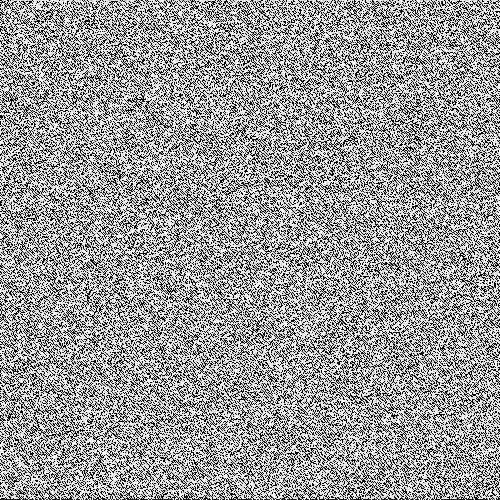

In [16]:
# DW 中，输入特征通道数与输出通道数是一样的
# DW kernel usually is 3 x 3
# DW convolution groups parameter equals to input channels

# 下面是PW
in_channels_pw = out_channels_dw
out_channels_pw = 4
kernel_size_pw = 1
pw = nn.Conv2d(in_channels_pw, out_channels_pw, kernel_size_pw, stride,padding='same')
out = pw(dw(x))
print(out.shape)

# display the first channel of the output feature map
img_out = Image.fromarray((out[0,0,:,:].detach().numpy() * 255).astype('uint8'))
display(img_out)

空洞卷积经常用于图像分割任务当中。图像分割任务的目的是要做到 pixel-wise 的输出，也就是说，对于图片中的每一个像素点，模型都要进行预测。

"感受野" 是指神经网络中某一层的一个神经元所能“看到”的输入数据的区域大小。在卷积神经网络（CNN）中，感受野决定了每个神经元在输入图像上能够感知的范围。
通过增加卷积核的感受野，可以使模型捕捉到更大范围的上下文信息，从而提高分割的精度。

(unet 通过卷积 + 池化逐级压缩分辨率、扩大感受野，然后再通过上采样逐级恢复分辨率 但是对于图像分割模型有个问题，经过多层的卷积与 pooling 操作之后，特征图会变小。为了做到每个像素点都有预测输出，我们需要对较小的特征图进行上采样或反卷积，将特征图扩大到一定尺度，然后再进行预测。)

BN 是 均值合方差标准化的一种实现方式。它通过对每一层的输入进行标准化处理，使得输入数据的分布更加稳定，从而加快模型的训练速度并提高模型的性能。

ReLU 激活函数在卷积神经网络中被广泛使用，主要有以下几个原因：
1. 非线性：ReLU 引入了非线性，使得神经网络能够学习和表示复杂的函数关系。这对于处理图像等复杂数据非常重要。
2. 计算效率高：ReLU 的计算非常简单，只需要比较输入值与零的大小，因此计算速度非常快。这有助于加快训练和推理过程。
3. 减少梯度消失问题：与传统的激活函数（如 sigmoid 和 tanh）相比，ReLU 在正区间内的梯度恒为 1，这有助于缓解梯度消失问题，使得深层网络更容易训练。
4. 稀疏激活：ReLU 会将负值置为零，这导致网络中的许多神经元在某些输入下不会被激活，从而产生稀疏的表示。这种稀疏性有助于提高模型的泛化能力。


从一个较小的特征图恢复到一个较大的特征图，这显然会带来一定的信息损失，特别是较小的物体，这种损失是很难恢复的。那问题来了，能不能既保证有比较大的感受野，同时又不用缩小特征图呢？估计你已经猜到了，空洞卷积就是解决这个问题的杀手锏，它最大的优点就是不需要缩小特征图，也可以获得更大的感受野。

## 举个例子
原图是 6x6 的图像，第一层卷积层为 3x3，这时它输出的感受野就是 3，因为输出的特征图中每个值都是由原图中 3x3 个区域计算而来的。
6 * 6 输入，通过 3x3 卷积核，输出 4 * 4 特征图，感受野为 3。

然后再经过一个 3x3 的卷积层，这时输出的感受野就是 5，因为输出的特征图中每个值都是由原图中 5x5 个区域计算而来的。
4 * 4 输入，通过 3x3 卷积核，输出 2 * 2 特征图，感受野为 5。

__感受野的计算公式为__：
感受野 = 前一层的感受野 + 当前层卷积核大小 - 1

标准卷积gif为

![standard_convolution.gif](mdfiles/standard_convolution.gif)

空洞卷积gif为

![dilated_convolution.gif](mdfiles/dilated_convolution.gif)

dilation 参数默认为 1，同样也是可以为 int 或者 tuple。当为 tuple 时，第一位代表行的信息，第二位代表列的信息。

空洞卷积可以增大卷积核的感受野，从而捕捉更大范围的上下文信息，而不增加计算量和参数数量。这对于图像分割等任务非常有用，因为它们需要对每个像素点进行预测，并且需要考虑更广泛的上下文信息。
__空洞卷积的感受野计算公式为__：
等效卷积核大小 = （卷积核大小 - 1） * dilation + 1
感受野 = 前一层的感受野 + 等效卷积核大小 - 1

```python
import torch
import torch.nn as nn
# 写一个 dilated convolution 的例子
# 生成一个单通道的7x7特征图
x = torch.rand((1, 1, 7, 7))
print(x.shape)

# 输出：
torch.Size([1, 1, 7, 7])

# 定义一个3x3的空洞卷积，dilation为2，padding为2，stride为1
dilated_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=2, dilation=2)
# 进行卷积操作
output = dilated_conv(x)
print(output.shape)
# 输出：
torch.Size([1, 1, 7, 7])
# 计算感受野
# 第一层卷积，感受野为3
receptive_field = 3
# 第二层卷积，感受野为3 + (3 - 1) * 2 = 7
receptive_field = receptive_field + (3 - 1) * 2
print("感受野大小为：", receptive_field)
# 输出：
感受野大小为： 7
```

In [18]:
#随机生成一个 3 通道的 128x128 的特征图，然后创建一个有 10 个卷积核且卷积核尺寸为 3x3（DW 卷积）的深度可分离卷积，对输入数据进行卷积计算。

x = torch.rand((1, 3, 128, 128))
in_channels_dw = x.shape[1]
out_channels_dw =  x.shape[1]
print(in_channels_dw, out_channels_dw)
kernel_size = 3
stride = 1

dw = nn.Conv2d(in_channels_dw, out_channels_dw, kernel_size, groups=in_channels_dw)

in_channels_PW = out_channels_dw
out_channels_PW = 10

pw = nn.Conv2d(in_channels_PW, out_channels_PW, kernel_size=1)

out = pw(dw(x))
print(out.shape)

3 3
torch.Size([1, 10, 126, 126])
